# Exploratory notebook for IMACLIM data-use within MatMat-Trade to input in MatMat

### Imports 

In [1]:
# make the necessary imports
import tqdm
import shutil
import warnings
import pandas as pd
import numpy as np
import multiprocessing

from main import Model,load_model
from src.utils import footprint_extractor,get_import_mean_stressor,get_total_imports_region,recal_stressor_per_region,get_total_imports_region,multi_footprints_extractor,save_footprints,save_Coef_Row
from src.scenarios import DICT_SCENARIOS
from src.advance import extract_data
from src.figures import*
from src.stressors import GHG_STRESSOR_NAMES,MATERIAL_STRESSOR_NAMES,STRESSORS_DICT_DEF

In [ ]:
import os, pathlib
path = pathlib.Path(os.getcwd()+os.sep+'figures'+os.sep+'best'+os.sep+'blabla'+os.sep+'blablabla')
path.mkdir(exist_ok=True, parents=True)

In [64]:
#from src.stressors import GHG_PARAMS
#print(GHG_PARAMS["proxy"])
#print(STRESSOR_DICT_GHG_MAT['GES'])
#{elt: GHG_AND_MATERIALS_PARAM["proxy"][elt] for elt in STRESSOR_DICT_GHG_MAT['GES']}
#filter(in(STRESSOR_DICT_GHG_MAT['GES']), GHG_AND_MATERIALS_PARAM["proxy"])
#set().union(STRESSOR_DICT_GHG_MAT['GES'])
from unidecode import unidecode
unidecode(''.join(elt[:4] +'_' for elt in 'GES'.split(' '))[:-1])

'GES'

In [6]:
#list(GHG_AND_MATERIALS_PARAM.keys())
list(STRESSORS_DICT_DEF.keys())

['full',
 'GES',
 'Matières premières',
 'Minerais métalliques',
 'Minéraux non-métalliques',
 'Biomasse',
 'Combustibles fossiles',
 'Usage des sols']

In [43]:
DICT_SCENARIOS.keys()

dict_keys(['best', 'best final demand', 'worst', 'worst final demand', 'pref_eu', 'tradewar_china', 'dummy', 'emissivity_IMACLIM', 'technical_change_IMACLIM', 'production_change_IMACLIM', 'consumption_change_imaclim'])

In [15]:
import imp
import src.figures

C:\Users\bruno\AppData\Local\Temp\ipykernel_21092\2266528902.py:1: DeprecationWarning:

the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses



In [16]:
imp.reload(src.figures)

<module 'src.figures' from 'C:\\Users\\bruno\\Documents\\CDD_CIRED_MatMat\\matmat_expés\\MatMat-Trade\\src\\figures.py'>

In [2]:
#c'est ici que l'on choisit le niveau d'aggrégation, ils sont définis dans "data/aggregation/NOM_DE_L_AGGREG.xlsx"
agg_name = 'ofce'
#model_no_cap = Model(aggregation_name="MatMat_sectors_all_countries",stressor_params=GHG_AND_MATERIALS_PARAM,exiobase_vanilla=True,calib=True)
#model_no_cap = Model(aggregation_name=agg_name,stressor_params=GHG_AND_MATERIALS_PARAM,exiobase_vanilla=True,calib=True)
#model_no_cap = Model(aggregation_name=agg_name,stressor_params=GHG_AND_MATERIALS_PARAM,exiobase_vanilla=True,calib=False)
model_no_cap = Model(aggregation_name=agg_name,recalib_capital=False,calib=False)

#Le paramètre "exiobase_vanilla" permet d'ignorer la recalibration sur la capital que tu avais mise en place, histoire d'avoir de résultats plus facilement comparable
# si "exiobase_vanilla" = False alors la recalibration a lieu

#ignore performace warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

### Building the counterfactual scenarios

In [37]:
scenario= "INDC2020_1000"   # to be chosen among availabble IMACLIM scenarios
YEAR=2050
agg_name = 'ofce'

model_no_cap.new_counterfactual("IMACLIM_"+agg_name+"_"+str(YEAR)+"_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=YEAR,scenario=scenario)
model_no_cap.modify_counterfactual("IMACLIM_"+agg_name+"_"+str(YEAR)+"_"+scenario, DICT_SCENARIOS["technical_change_IMACLIM"], year=YEAR,scenario=scenario)
# We have created a counterfactual scenario named "IMACLIM_all_2050_INDC" for the year 2050 based on IMACLIM trends

In [4]:
# here we build the different variation of our trade scenarios for both the base year and 2050

# for the 2050 trade scenario we use the method "modify counterfactual" to apply the scenarios to the already existing counterfactual "IMACLIM_all_2050_INDC"

#model_no_cap.new_counterfactual("best_final",DICT_SCENARIOS["best final demand"])
model_no_cap.new_counterfactual("best",DICT_SCENARIOS["best"])
model_no_cap.new_counterfactual("worst",DICT_SCENARIOS["worst"])
model_no_cap.new_counterfactual("china",DICT_SCENARIOS["tradewar_region"])


In [39]:
model_no_cap.modify_counterfactual("IMACLIM_"+agg_name+"_2050_INDC2020_1000",DICT_SCENARIOS["best final demand"],new_name="best_final_2050")
model_no_cap.modify_counterfactual("IMACLIM_"+agg_name+"_2050_INDC2020_1000",DICT_SCENARIOS["best"],new_name="best_2050")
#model_no_cap.new_counterfactual("best_scope_1",DICT_SCENARIOS["best"],scope=1)
#model_no_cap.modify_counterfactual("IMACLIM_all_2050_INDC",DICT_SCENARIOS["best"],new_name="best_2050_scope_1",scope=1)

In [ ]:
import tqdm
scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]

for scenario in tqdm.tqdm(scenario_list):
    model.new_counterfactual("IMACLIM_all_2015_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2015,scenario=scenario)
    model.modify_counterfactual("IMACLIM_all_2015_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2015,scenario=scenario)
    
    model.new_counterfactual("IMACLIM_all_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario)
    
    model.new_counterfactual("IMACLIM_emissivity_2015_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2015,scenario=scenario)
    model.new_counterfactual("IMACLIM_emissivity_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)

In [ ]:
from src.utils import footprint_extractor

all=pd.concat([ pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_"+str(year)+"_"+scenario],"FR"),index=[scenario+str(year)])["Importations"] for scenario in scenario_list for year in [2015,2050]],
          keys=[(scenario,year) for scenario in scenario_list for year in [2015,2050]]
          )
emissivity=pd.concat([ pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_emissivity_"+str(year)+"_"+scenario],"FR"),index=[scenario+str(year)])["Importations"] for scenario in scenario_list for year in [2015,2050]],
          keys=[(scenario,year) for scenario in scenario_list for year in [2015,2050]]
          )

In [ ]:
pd.concat([emissivity,all],
          keys=["emissivity_change","emissivity_and_tech_change"])

In [ ]:
model.modify_counterfactual("IMACLIM_emissivity_2016_INDC2030_1000",DICT_SCENARIOS["technical_change_IMACLIM"], year=2016,scenario="INDC2030_1000")

In [ ]:
model.plot_footprint_FR()
for year in range(2016,2050,10):
    model.plot_footprint_FR(counterfactual_name="IMACLIM_"+str(year))
    # model.plot_footprint_FR(counterfactual_name="IMACLIM_tech"+str(year))

In [ ]:
from src.utils import footprint_extractor
print(footprint_extractor(model,"FR"))
print(footprint_extractor(model.counterfactuals["best"],"FR"))
print(footprint_extractor(model.counterfactuals["best_scope_1"],"FR"))


In [16]:
model_no_cap.save()

In [12]:
model_no_cap.counterfactuals['best'].iot.stressor_extension.__dict__.keys()

dict_keys(['name', 'F', 'F_Y', 'S', 'S_Y', 'M', 'D_cba', 'D_pba', 'D_imp', 'D_exp', 'unit', '__basic__', '__D_accounts__', '__non_agg_attributes__', '__coefficients__', 'D_cba_reg', 'D_pba_reg', 'D_imp_reg', 'D_exp_reg', 'D_cba_cap', 'D_pba_cap', 'D_imp_cap', 'D_exp_cap'])

In [9]:
model_no_cap.counterfactuals['best'].iot.stressor_extension.D_cba

region                             FR                               \
sector                    Agriculture    Crude coal      Crude oil   
region                                                               
FR     CO2 - combustion  4.242099e+09  1.381699e+07   31251.365948   
       CO2 - other       5.530764e+08  4.107818e+03     100.712236   
       CH4               1.581212e+10  3.762974e+04  356713.218178   
       N2O               9.712800e+09  9.304391e+04     547.297049   
       SF6               2.800238e+07  2.819000e+03      25.891902   
...                               ...           ...            ...   
EU     Cropland          1.603792e+04  4.779661e-02       0.001455   
       Forests           1.857822e+04  5.536729e-02       0.001685   
       Pastures          5.919962e+03  1.764282e-02       0.000537   
       Infrastructures   0.000000e+00  0.000000e+00       0.000000   
       Other land Use    8.493146e+03  2.531149e-02       0.000770   

region                                                                      \
sector                    Natural gas Extractive industry Biomass_industry   
region                                                                       
FR     CO2 - combustion  2.875284e+09        5.732184e+06     9.419376e+09   
       CO2 - other       2.021421e+07        8.373591e+04     4.396673e+08   
       CH4               2.753068e+08        3.615024e+05     9.903264e+09   
       N2O               7.767484e+06        1.263594e+05     5.998077e+09   
       SF6               4.786063e+05        4.797260e+05     3.631039e+07   
...                               ...                 ...              ...   
EU     Cropland          2.587884e+01        4.161221e-01     1.556790e+04   
       Forests           2.997788e+01        4.820332e-01     1.803376e+04   
       Pastures          9.552472e+00        1.536002e-01     5.746468e+03   
       Infrastructures   0.000000e+00        0.000000e+00     0.000000e+00   
       Other land Use    1.370457e+01        2.203644e-01     8.244241e+03   

region                                                              \
sector                       Clothing Heavy_industry  Construction   
region                                                               
FR     CO2 - combustion  3.810920e+08   1.059183e+10  1.278516e+10   
       CO2 - other       1.539306e+07   2.676869e+09  1.240407e+09   
       CH4               7.565853e+07   6.293569e+08  2.533160e+09   
       N2O               2.770073e+07   1.941725e+08  9.658119e+08   
       SF6               5.635601e+05   2.466099e+07  5.415351e+07   
...                               ...            ...           ...   
EU     Cropland          4.744205e+02   6.797544e+02  1.878586e+03   
       Forests           5.495657e+02   7.874233e+02  2.176142e+03   
       Pastures          1.751195e+02   2.509129e+02  6.934291e+02   
       Infrastructures   0.000000e+00   0.000000e+00  0.000000e+00   
       Other land Use    2.512373e+02   3.599753e+02  9.948365e+02   

region                                 ...             EU                \
sector                     Automobile  ... Heavy_industry  Construction   
region                                 ...                                
FR     CO2 - combustion  2.262622e+09  ...   1.765127e+09  1.515526e+09   
       CO2 - other       2.119885e+08  ...   3.678427e+08  1.927686e+08   
       CH4               3.176651e+08  ...   1.885492e+08  3.255739e+08   
       N2O               8.144703e+07  ...   8.007349e+07  1.564908e+08   
       SF6               3.658050e+06  ...   4.374998e+06  3.677368e+06   
...                               ...  ...            ...           ...   
EU     Cropland          7.178831e+02  ...   4.799188e+03  1.828866e+04   
       Forests           8.315912e+02  ...   5.559349e+03  2.118546e+04   
       Pastures          2.649871e+02  ...   1.771490e+03  6.750762e+03   
       Infrastructures   0.000000e+00  ...   

### Producing CoefRoW excels

In [29]:
from src.settings import BASE_DIR
Model_name="MatMat_sectors_"+agg_name+"_without_capital" # this is the name that will be used to name the excels
Path=BASE_DIR/("Outputs/CoefRow/{}.xlsx".format(Model_name)) # path to save excels 

In [30]:
Path

WindowsPath('C:/Users/bruno/Documents/CDD_CIRED_MatMat/matmat_expés/MatMat-Trade/Outputs/CoefRow/MatMat_sectors_ofce_without_capital.xlsx')

In [8]:
# opening the excels SRIO sheets to be able to translate from hybrid to monetaire units 
# make the necesssary adjustements to the path

SRIO_hyb=pd.read_excel("../Data/MatMat/SRIO_FR 2015.xlsx",sheet_name="hybride",header=[0,1,2],index_col=[0,1,2,3])
SRIO_monetaire=pd.read_excel("../Data/MatMat/SRIO_FR 2015.xlsx",sheet_name="monetaire",header=[0,1,2],index_col=[0,1,2,3])

In [9]:
# isolating the gross outputs
X_hyb=SRIO_hyb.loc[:,(slice(None),slice(None),"x")]
X_monetaire=SRIO_monetaire.loc[:,(slice(None),slice(None),"x")]

In [10]:
Transition_hybride_monetaire_RoW=(X_monetaire/X_hyb).fillna(0).loc["RoW"]
Transition_hybride_monetaire_RoW=Transition_hybride_monetaire_RoW.reset_index(["category","sub_category"])[("Supply","Supply","x")].fillna(0)

In [31]:
save_Coef_Row(model_no_cap,Transition_hybride_monetaire_RoW,Path)

In [43]:
model_no_cap.sectors

['Agriculture',
 'Crude coal',
 'Crude oil',
 'Natural gas',
 'Extractive industry',
 'Biomass_industry',
 'Clothing',
 'Heavy_industry',
 'Construction',
 'Automobile',
 'Oth transport equipment',
 'Machinery',
 'Electronics',
 'Fossil fuels',
 'Electricity and heat',
 'Transport services',
 'Composite']

In [19]:
#model_no_cap.counterfactuals.pop('IMACLIM_all_2050_INDC')
#model_no_cap.counterfactuals.pop('best_final')

In [12]:
#STRESSOR_DICT_GHG_MAT['Matières premières']
STRESSORS_DICT_DEF['Matières premières']

{'dict': ['Metal Ores',
  'Forestry',
  'Primary Crops',
  'Non-Metallic Minerals',
  'Fossil Fuels'],
 'unit': 'kt',
 'name_EN': 'Materials'}

In [41]:
print(model_no_cap.iot.stressor_extension.S.loc[STRESSORS_DICT_DEF['GES']['dict']]['FR'])
print(model_no_cap.counterfactuals['best'].iot.stressor_extension.S.loc[STRESSORS_DICT_DEF['GES']['dict']]['FR'])
print(model_no_cap.counterfactuals['worst'].iot.stressor_extension.S.loc[STRESSORS_DICT_DEF['GES']['dict']]['FR'])

sector              Agriculture    Crude coal     Crude oil    Natural gas  \
CO2 - combustion  118300.034517  1.605084e+06  1.677307e+05  299625.588830   
CO2 - other        19327.950982  0.000000e+00  0.000000e+00       0.000000   
CH4               582515.677420  3.433804e+02  2.098384e+06   27435.322523   
PFC                  299.593264  1.030158e+02  5.958495e+01       4.980849   
N2O               359802.866468  1.036141e+04  2.594910e+03     147.196628   
SF6                  968.828489  3.003983e+02  1.156648e+02      12.252907   
HFC                51724.593932  1.608868e+04  7.006032e+03     628.857010   

sector            Extractive industry  Biomass_industry      Clothing  \
CO2 - combustion         98681.555376      48289.932538  19409.880228   
CO2 - other                  0.000000        193.406039      0.000000   
CH4                        253.345114       1596.604113    279.581220   
PFC                       3630.515725         53.741718      4.575009   
N2O       

In [37]:
Transition_hybride_monetaire_RoW

sector
Paddy rice                 0.824903
Wheat                      0.634483
Cereal grains nec          0.530892
Vegetables, fruit, nuts    1.141138
Oil seeds                  0.468771
                             ...   
Real estate                1.000000
Hotel_Restaurant           1.000000
Commerce                   1.000000
Other_Business_Services    1.000000
Public_Services            1.000000
Name: (Supply, Supply, x), Length: 87, dtype: float64

In [36]:
model_no_cap.regions

['FR',
 'South America',
 'North America',
 'United States',
 'Row Europe',
 'China',
 'Africa',
 'Russia',
 'Asia',
 'Middle East',
 'Oceania',
 'EU']

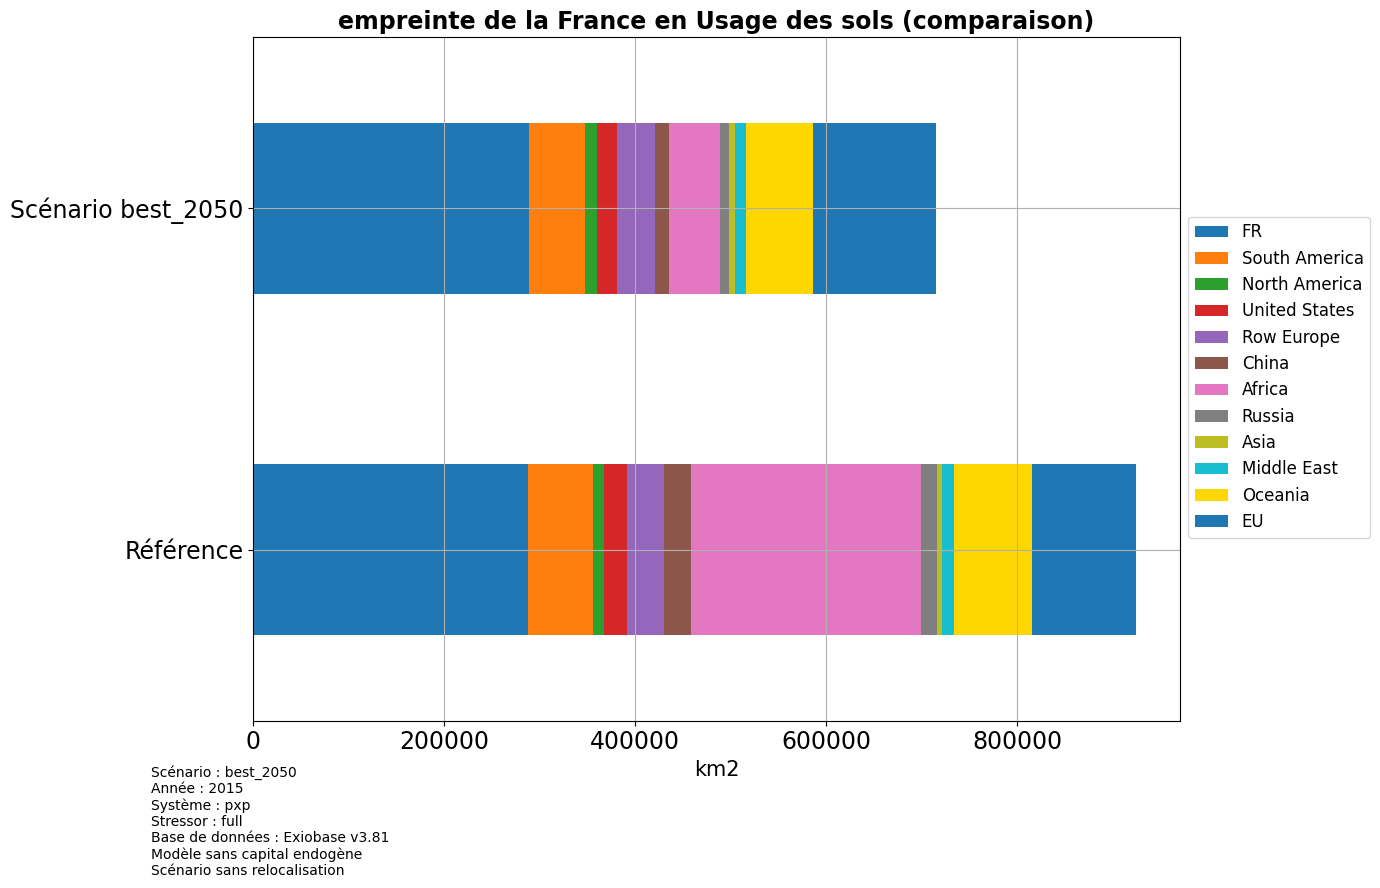

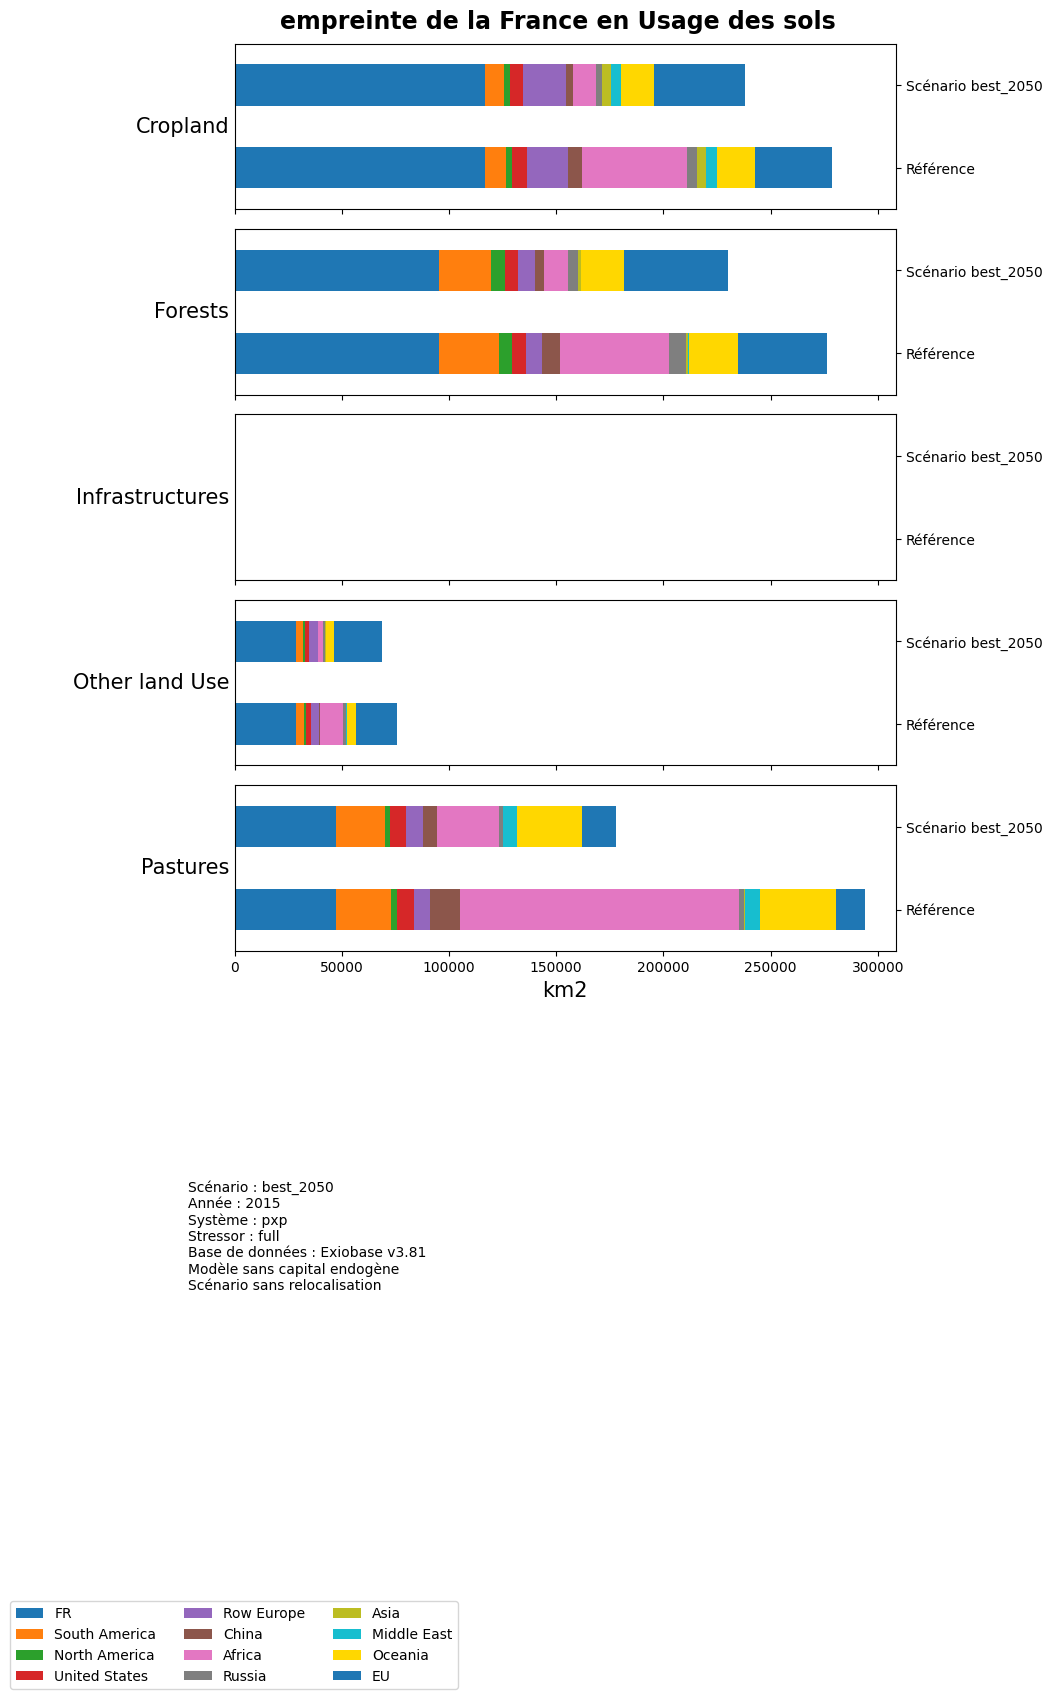

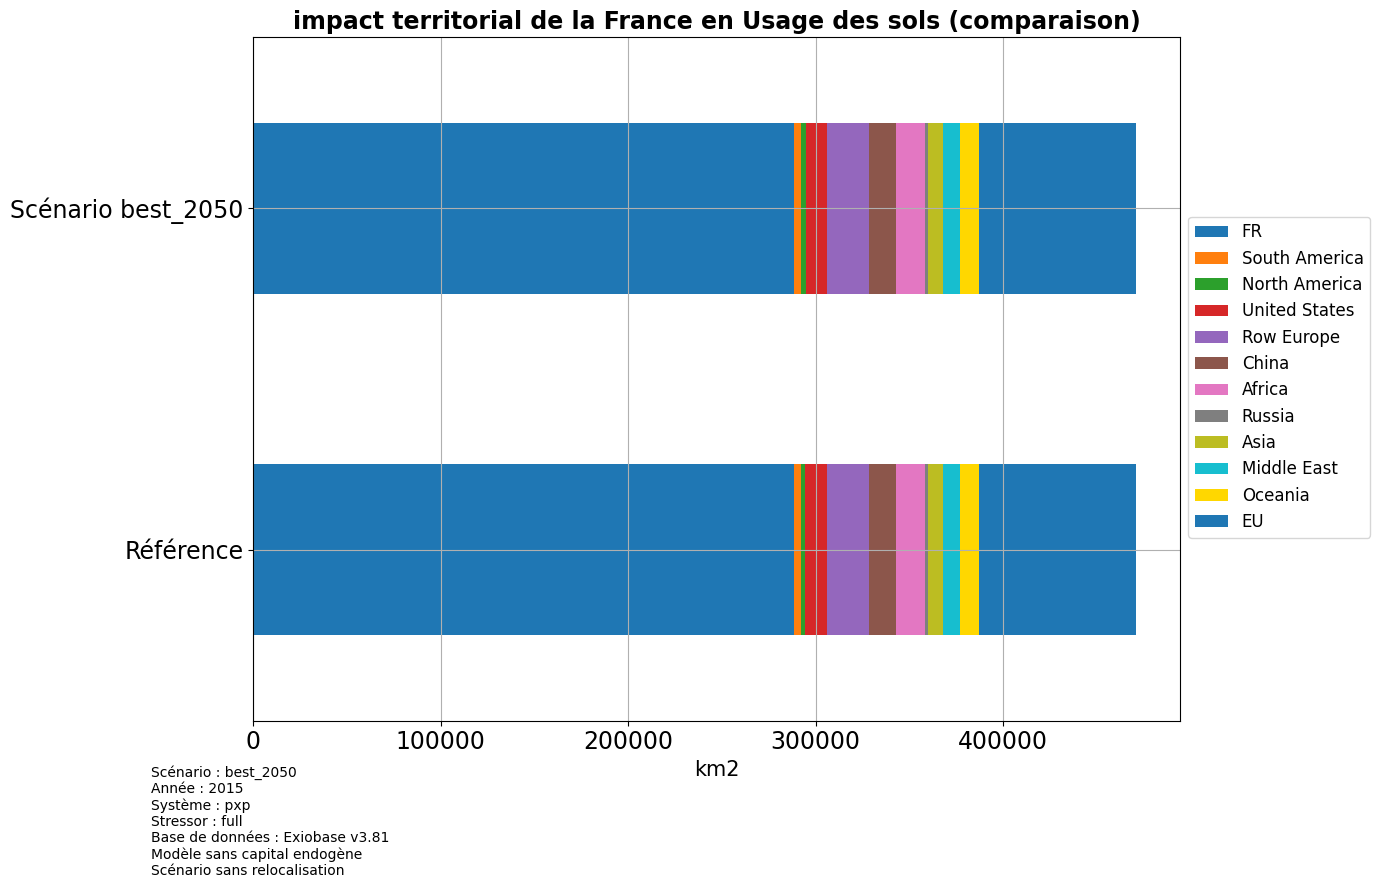

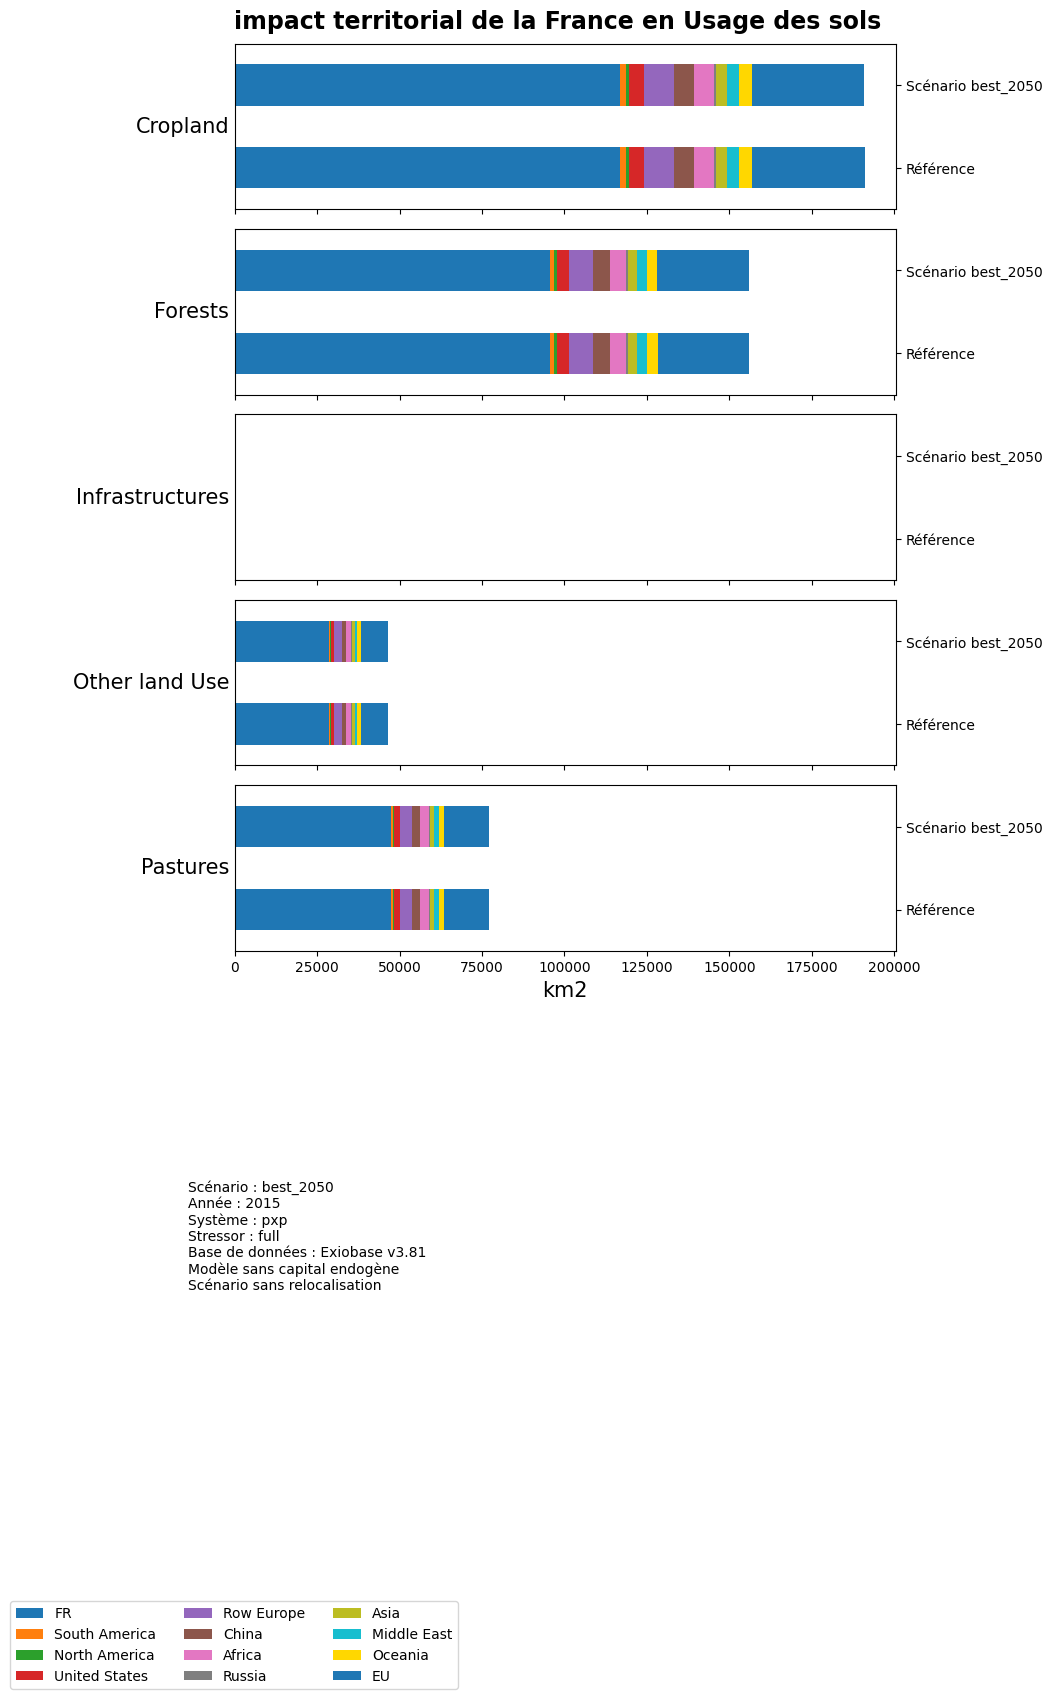

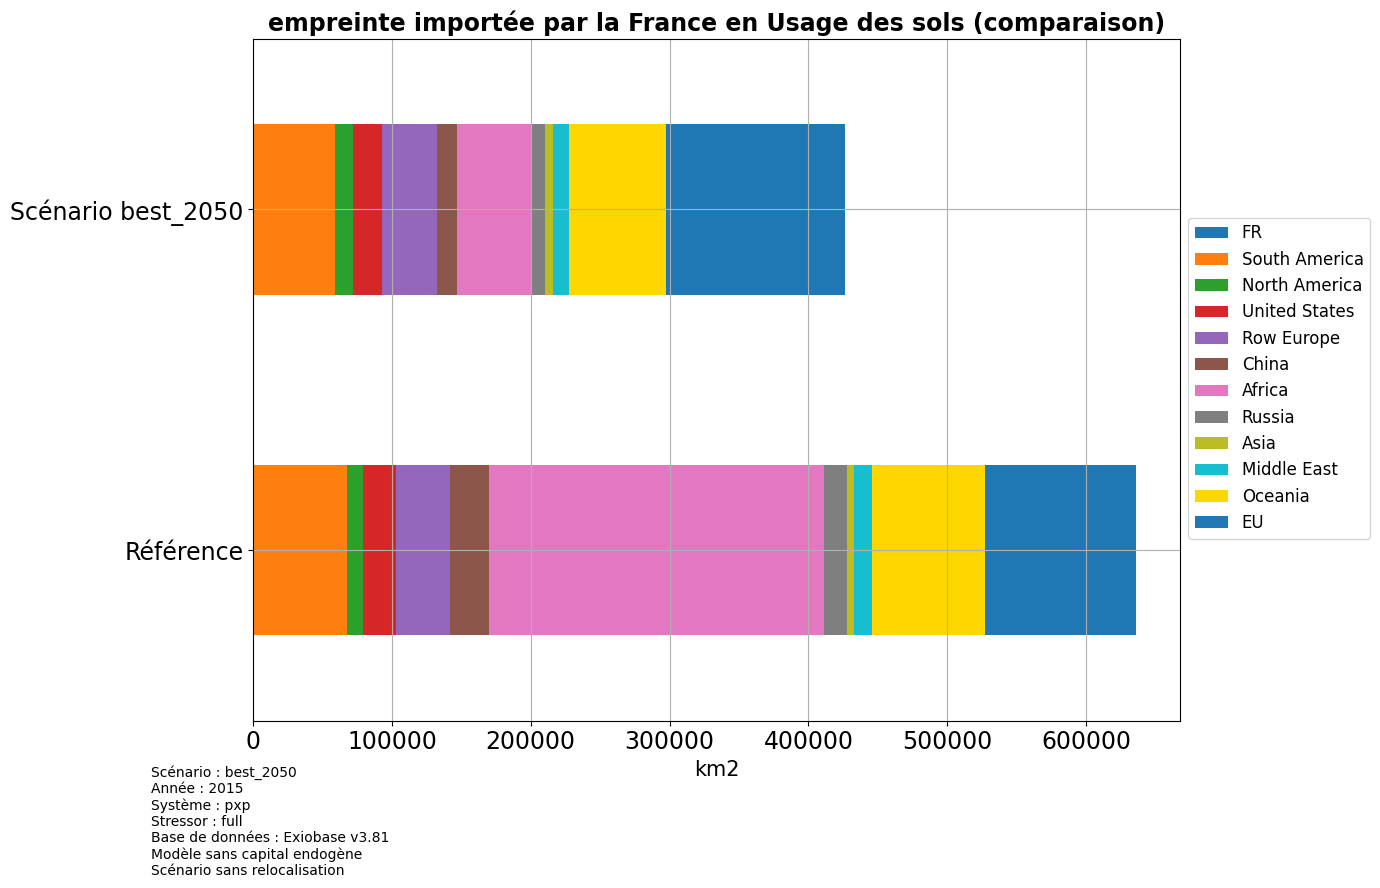

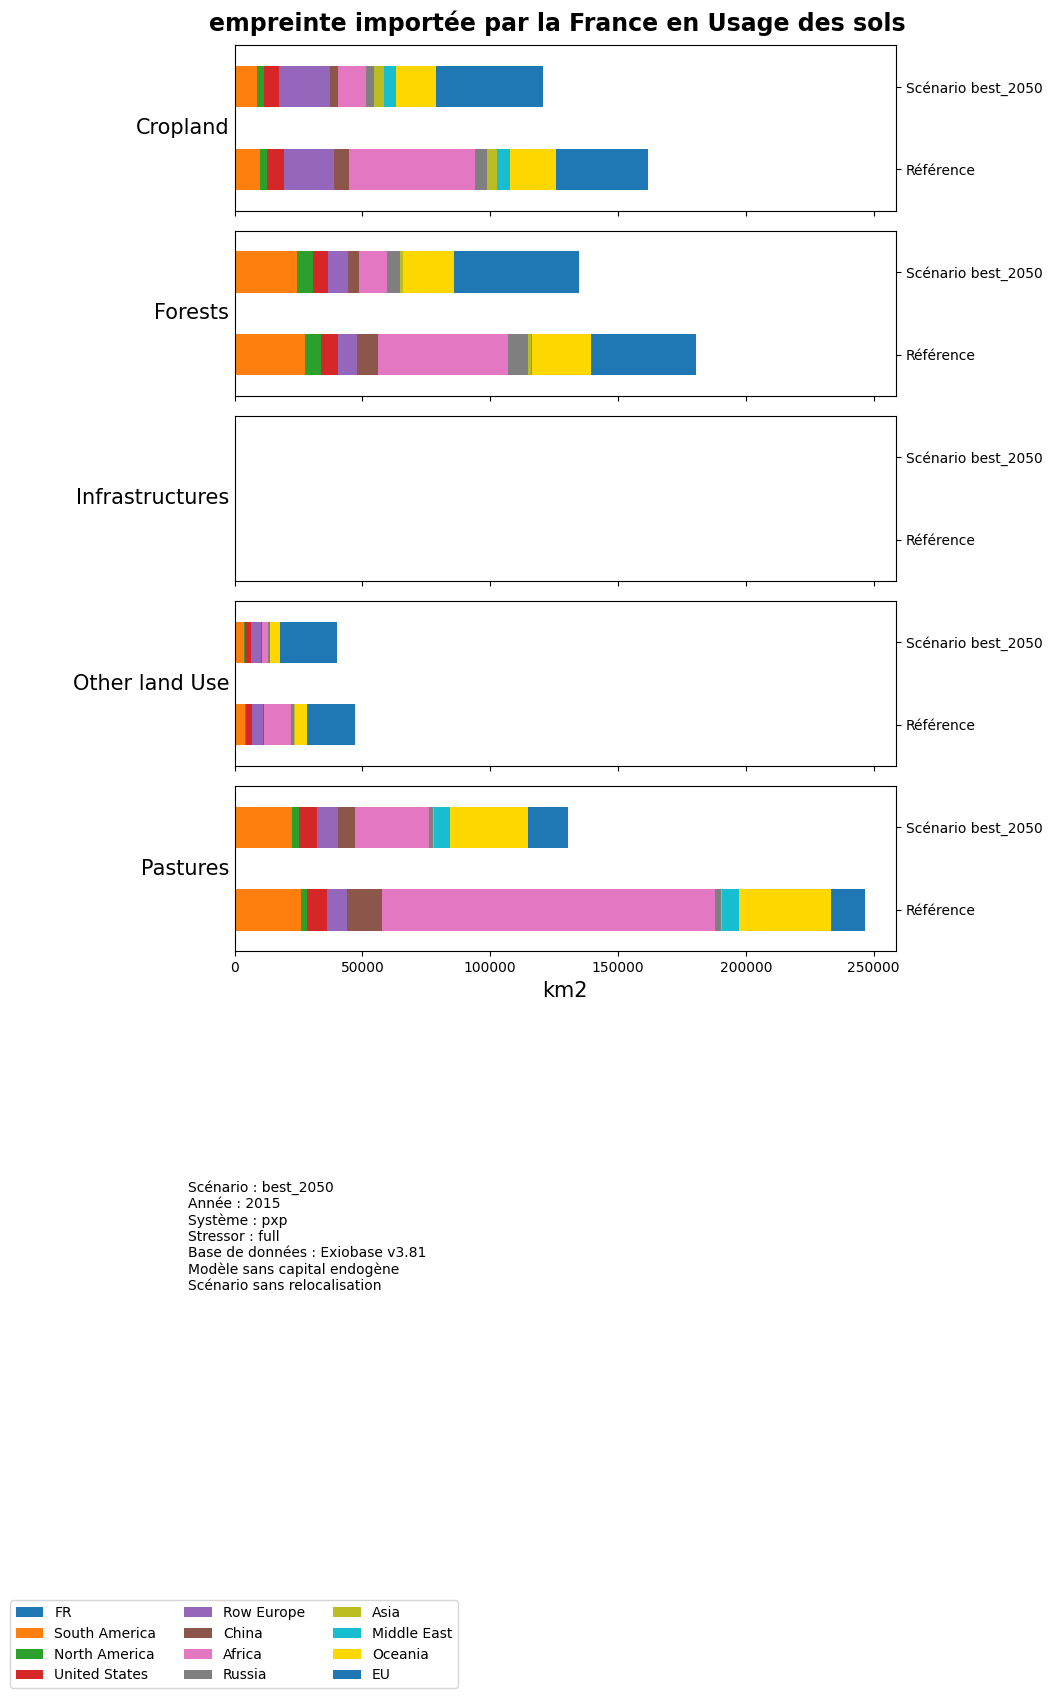

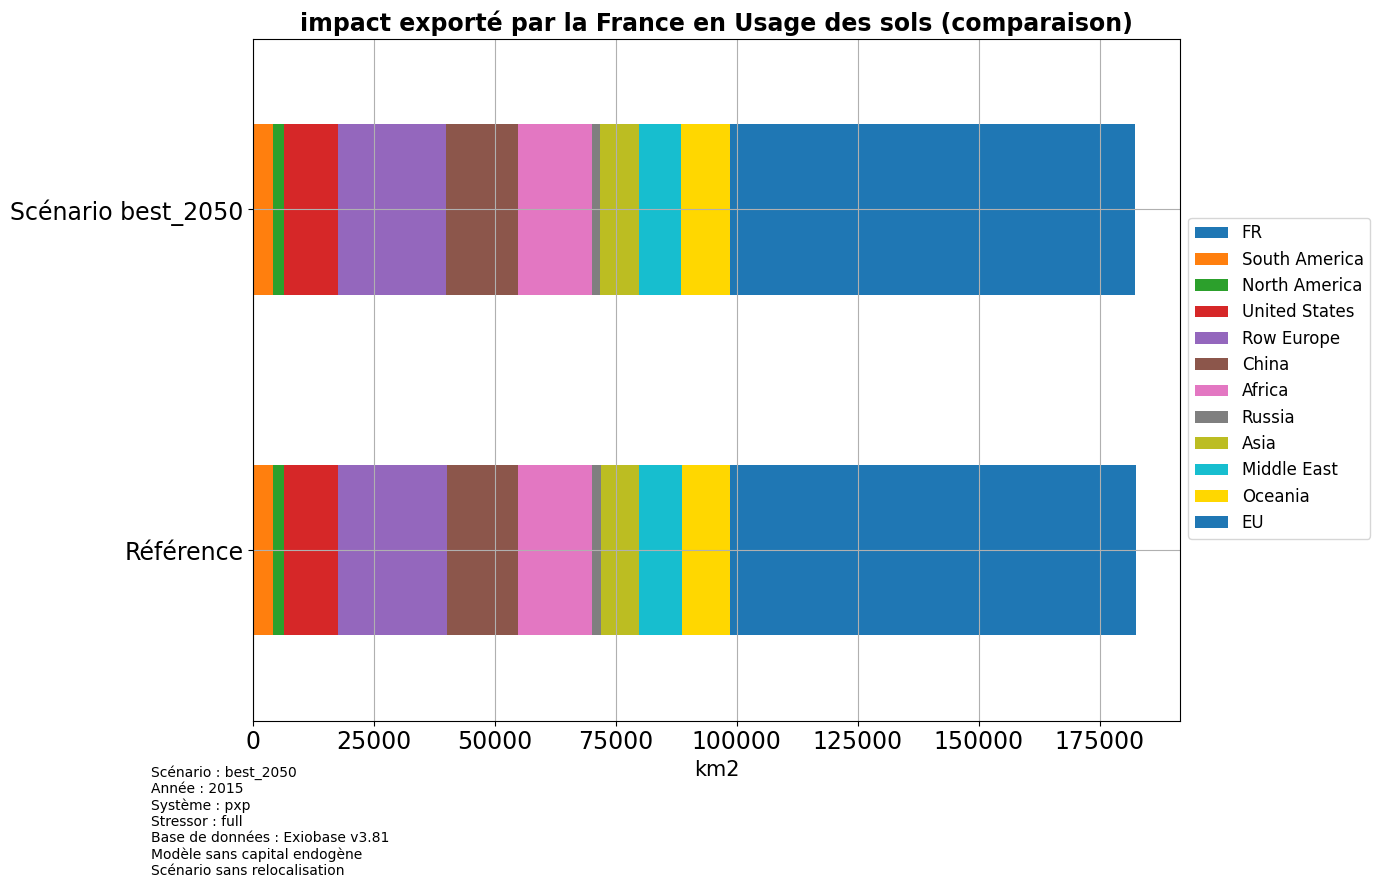

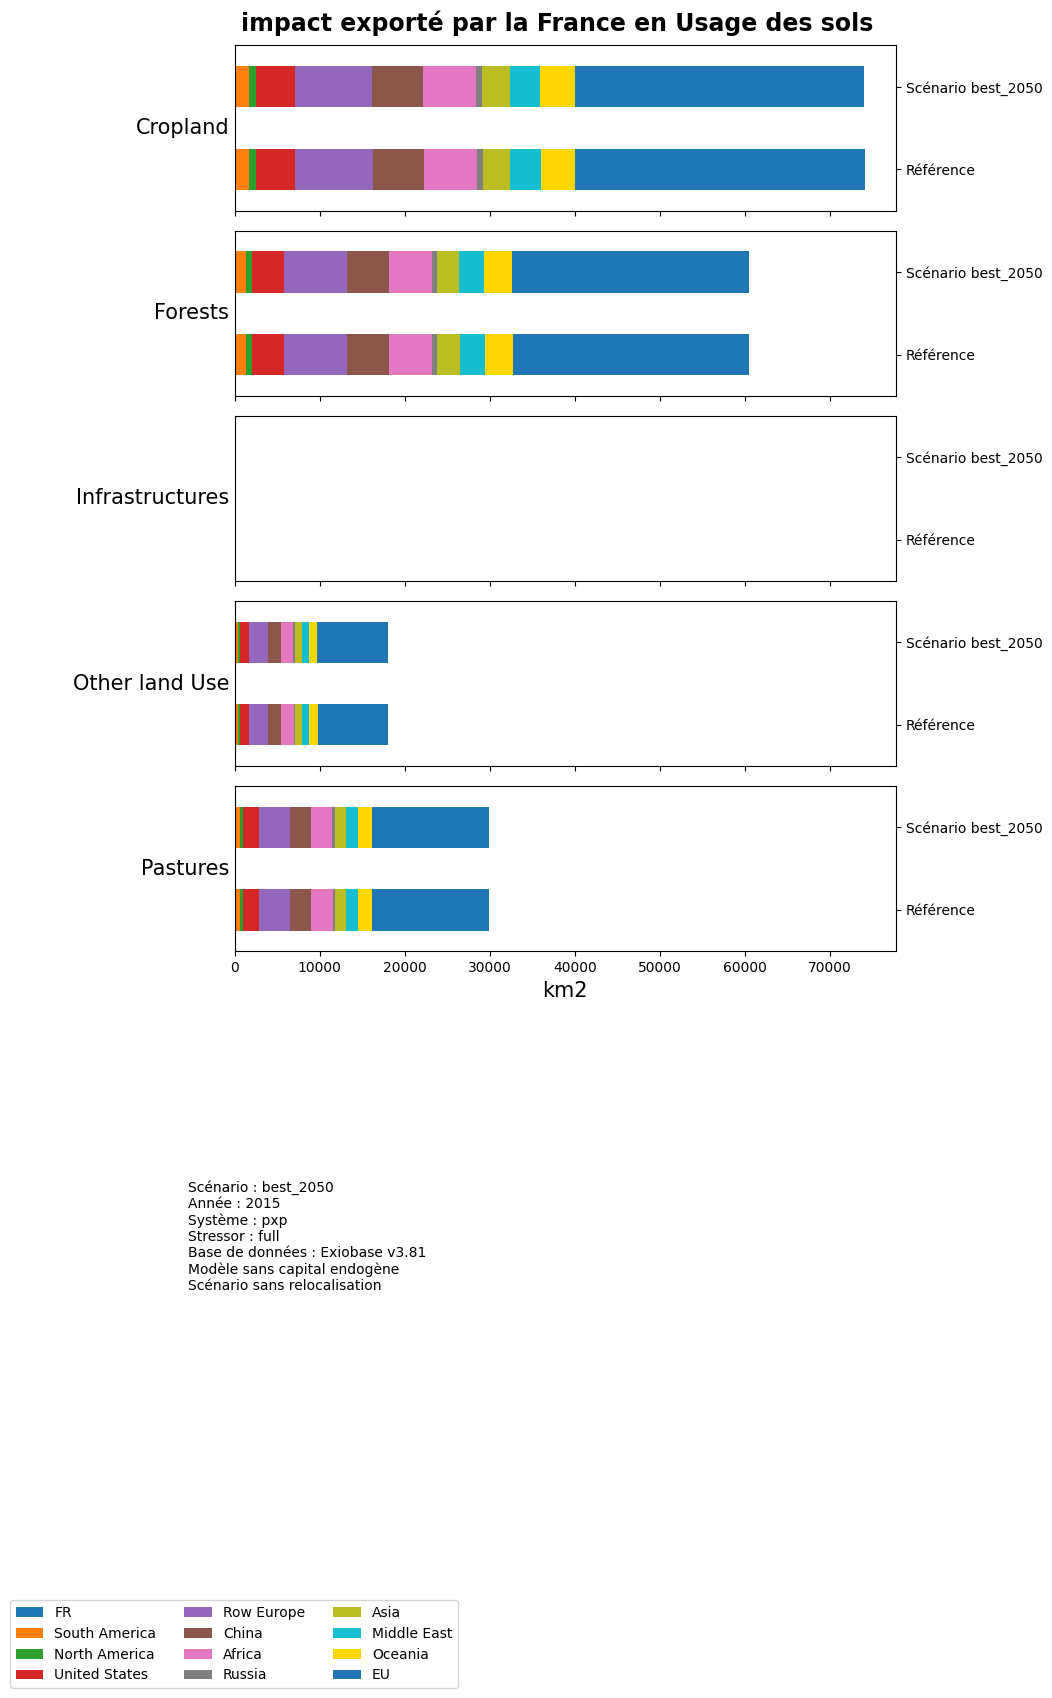

In [49]:
#model_no_cap.plot_substressor_synthesis("china", 'Matières premières')
model_no_cap.plot_substressor_synthesis("best_2050", 'Usage des sols')


In [116]:
imp.reload(src.settings)
from src.settings import SECTORS_AGG
from src.settings import REGIONS_AGG

In [75]:
print(REGIONS_AGG)
model_no_cap.regions


{'FR': ['FR'], 'China+': ['China', 'Asia'], 'Europe+': ['EU', 'RoW Europe'], 'North_Amer': ['United States', 'North America'], 'RoW': ['Middle East', 'Africa', 'Oceania', 'Russia', 'South America']}


['FR',
 'South America',
 'North America',
 'United States',
 'Row Europe',
 'China',
 'Africa',
 'Russia',
 'Asia',
 'Middle East',
 'Oceania',
 'EU']

In [119]:
model_no_cap.sectors_mapper = None
model_no_cap.regions_mapper = None

In [122]:
model_no_cap.sectors_mapper = SECTORS_AGG
model_no_cap.regions_mapper = REGIONS_AGG

In [115]:
print(model_no_cap.rev_regions_mapper)
model_no_cap.regions_mapper
print(model_no_cap.regions)
model_no_cap.new_regions_index

{'FR': 'FR', 'China': 'China+', 'Asia': 'China+', 'EU': 'Europe+', 'RoW Europe': 'Europe+', 'United States': 'North_Amer', 'North America': 'North_Amer', 'Middle East': 'RoW', 'Africa': 'RoW', 'Oceania': 'RoW', 'Russia': 'RoW', 'South America': 'RoW'}
['FR', 'South America', 'North America', 'United States', 'Row Europe', 'China', 'Africa', 'Russia', 'Asia', 'Middle East', 'Oceania', 'EU']


Index(['FR', 'China+', 'Europe+', 'North_Amer', 'RoW'], dtype='object')

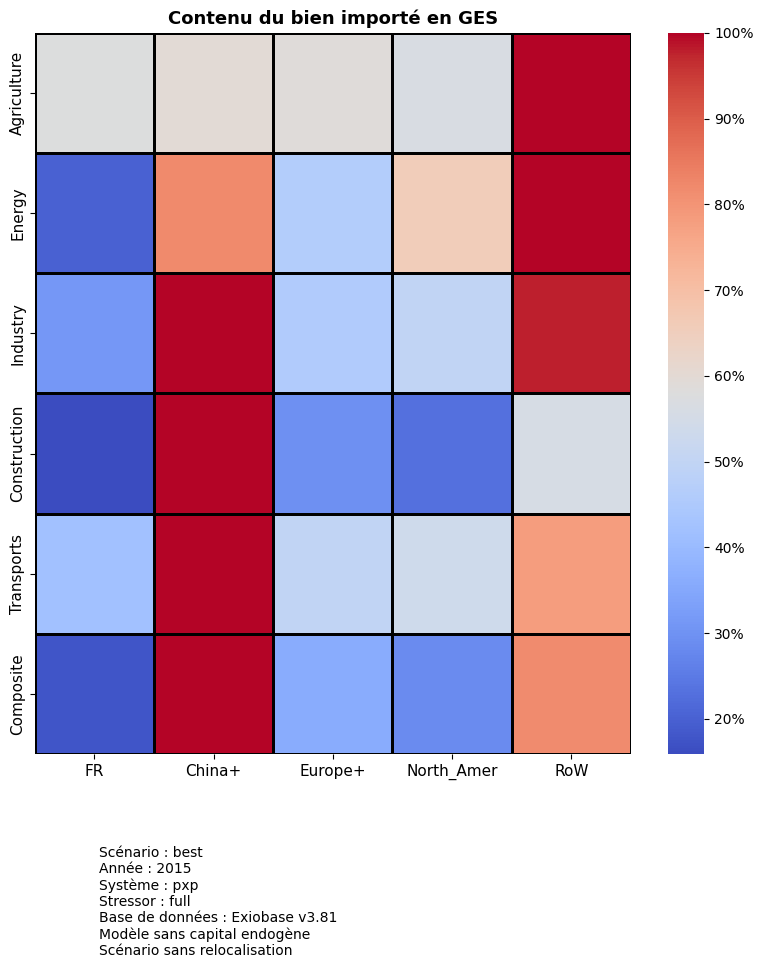

In [123]:
#model_no_cap.plot_stressor_content_production("best_2050", stressors_to_display = 'GES')
#model_no_cap.sectors_mapper = SECTORS_AGG
#model_no_cap.sectors_mapper = REGIONS_AGG
model_no_cap.plot_stressor_content_heatmap("best", 'GES', prod = False)

#model_no_cap.plot_stressor_content_production("best_2050", stressors_to_display = 'GES')

In [52]:
model_no_cap.plot_stressor_synthesis("best", stressors_to_display='GES')

TypeError: plot_stressor_synthesis() missing 1 required positional argument: 'stressors_to_display'

In [ ]:
model_no_cap.plot_stressor_content_heatmap("best", 'GES', prod = False)
model_no_cap.plot_stressor_content_heatmap("best", 'Matières premières', prod = False)
model_no_cap.plot_stressor_content_heatmap("best", 'Matières premières', prod = True)

In [ ]:
model_no_cap.plot_stressor_content_production("best", 'Matières premières')

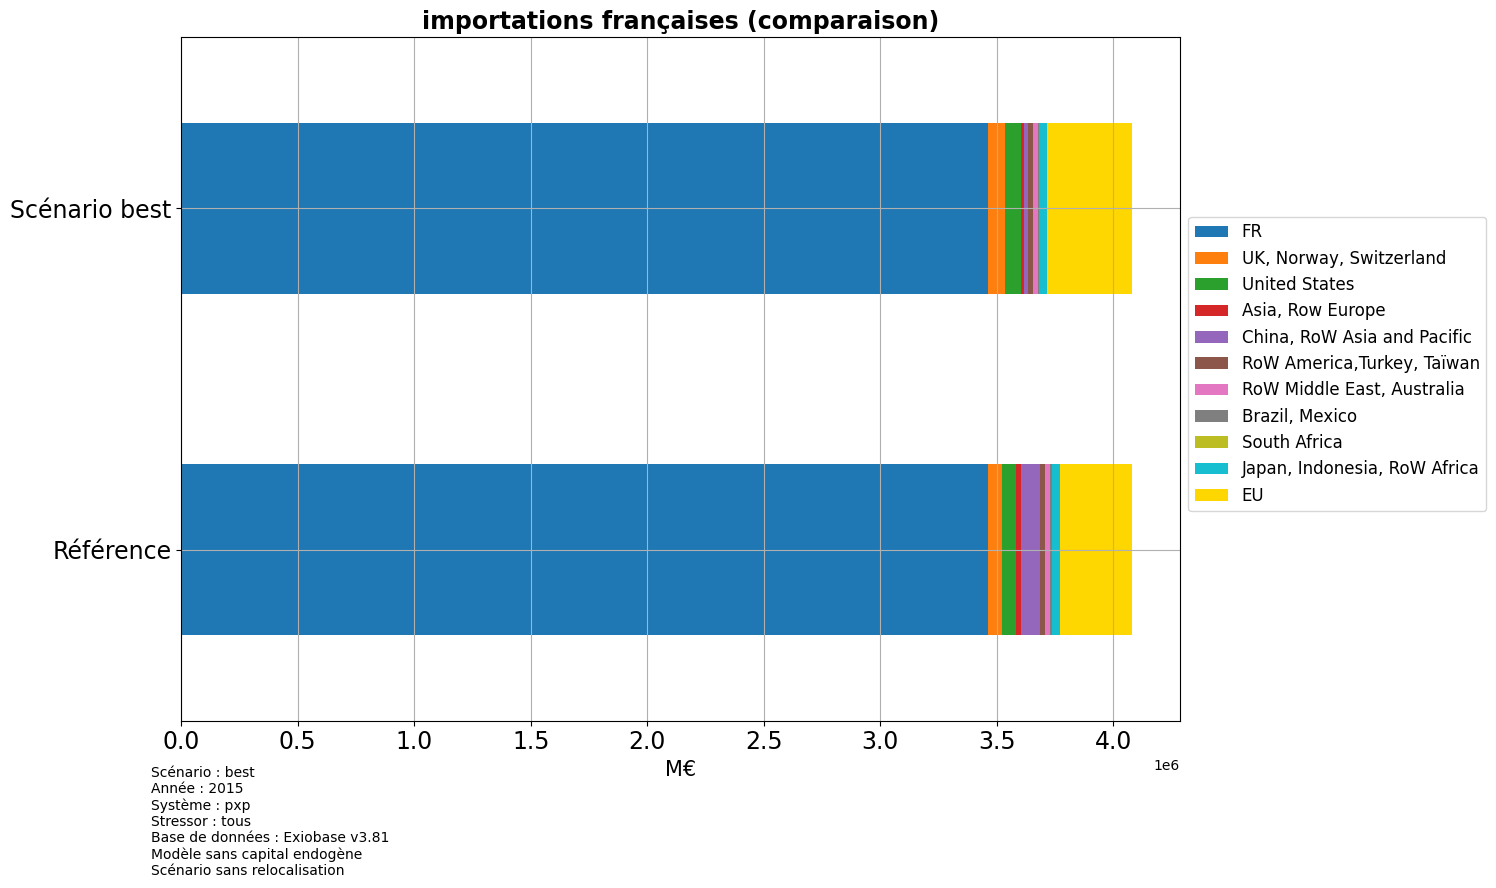

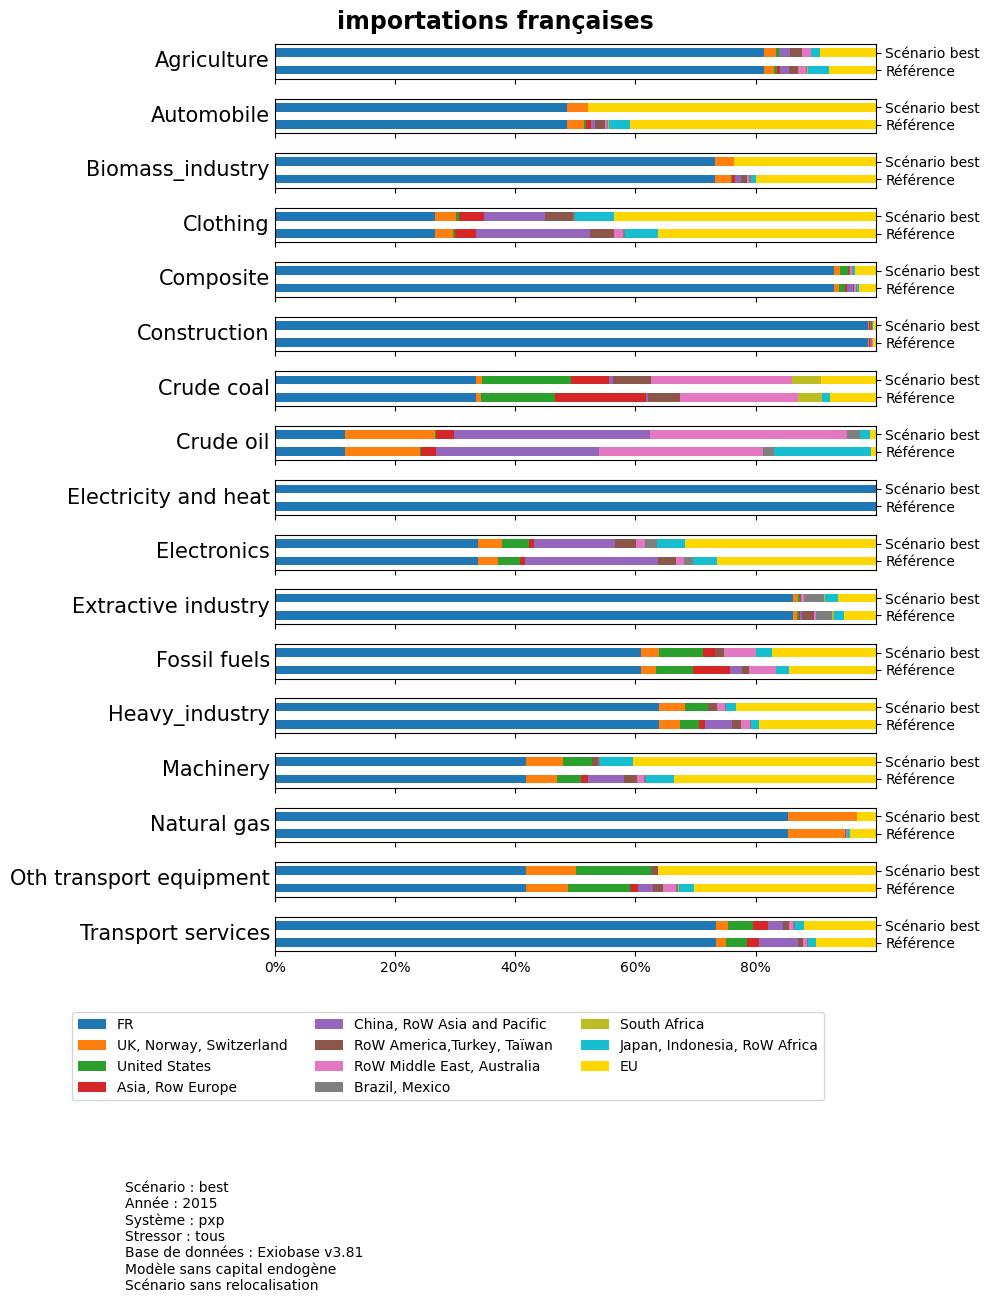

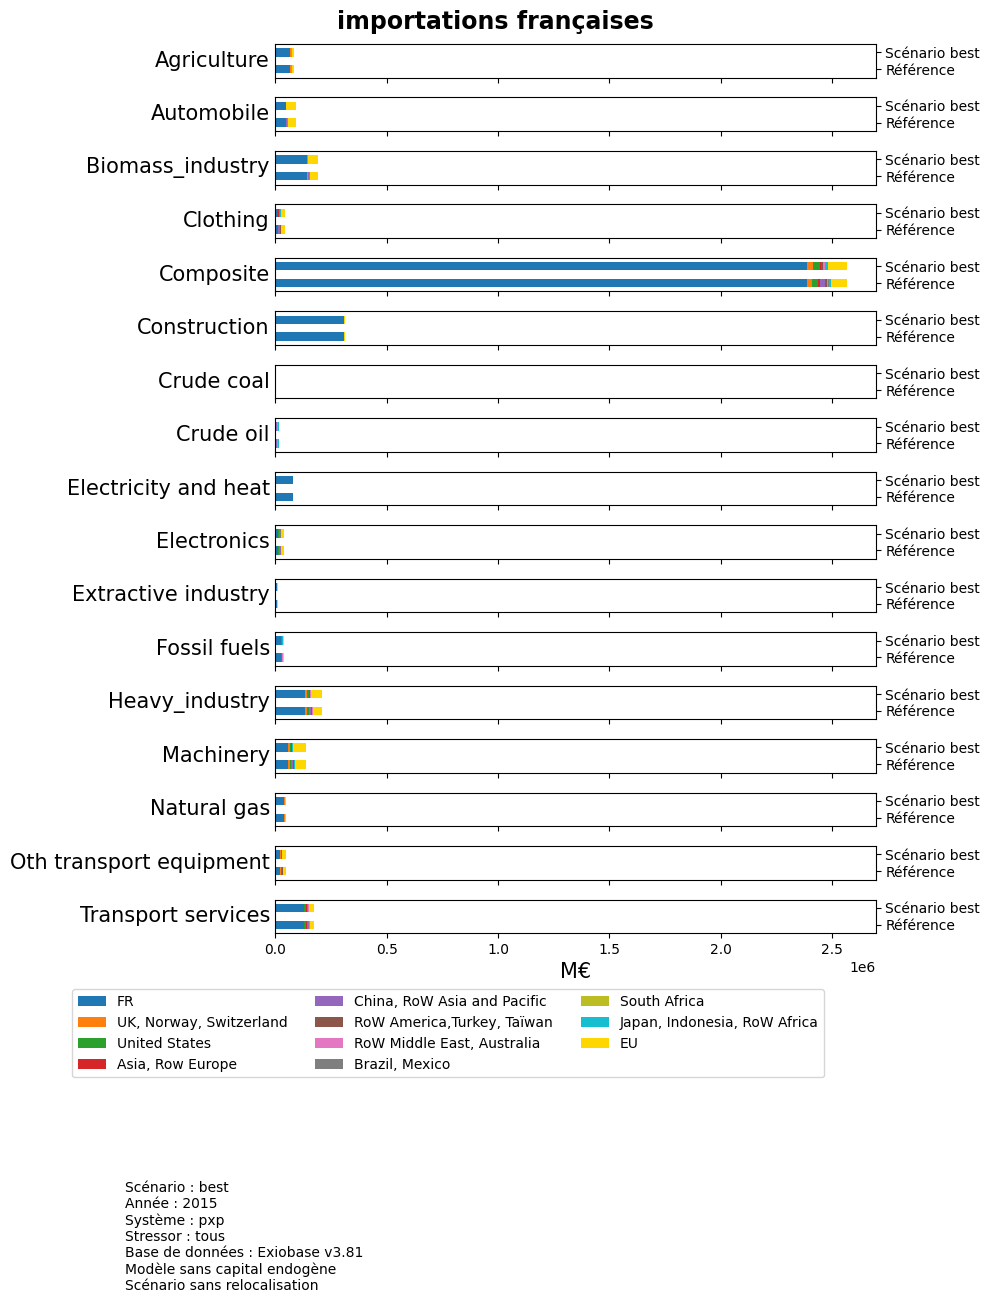

In [16]:
model_no_cap.plot_trade_synthesis('best')

In [19]:
#model_no_cap.compare_scenarios(verbose = True)

Comparing scenarios...
Processing best


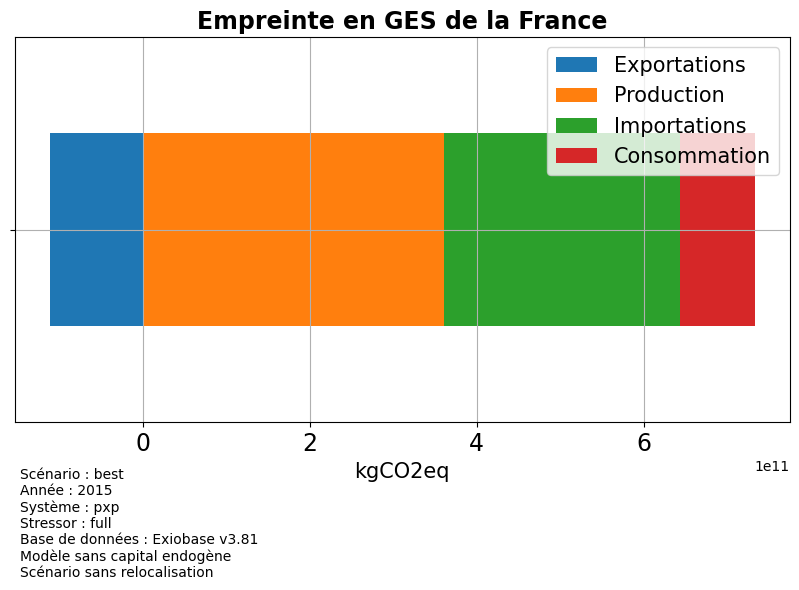

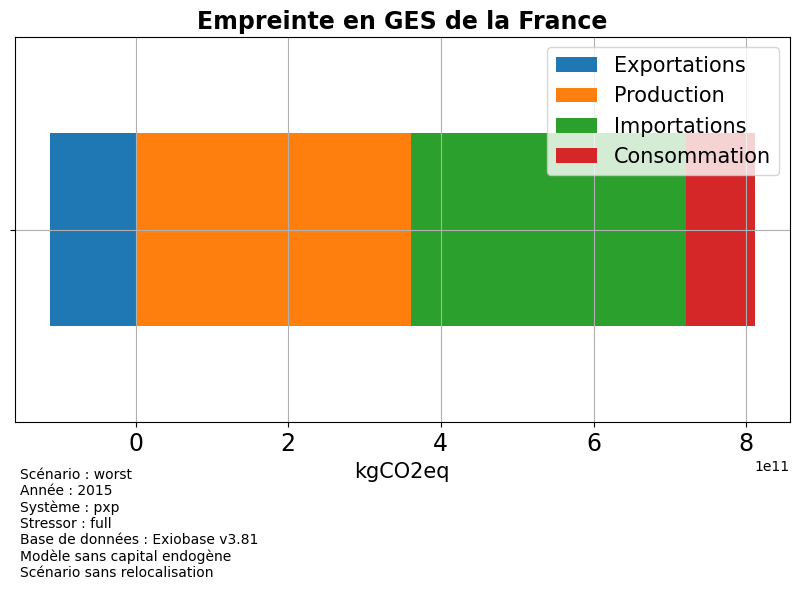

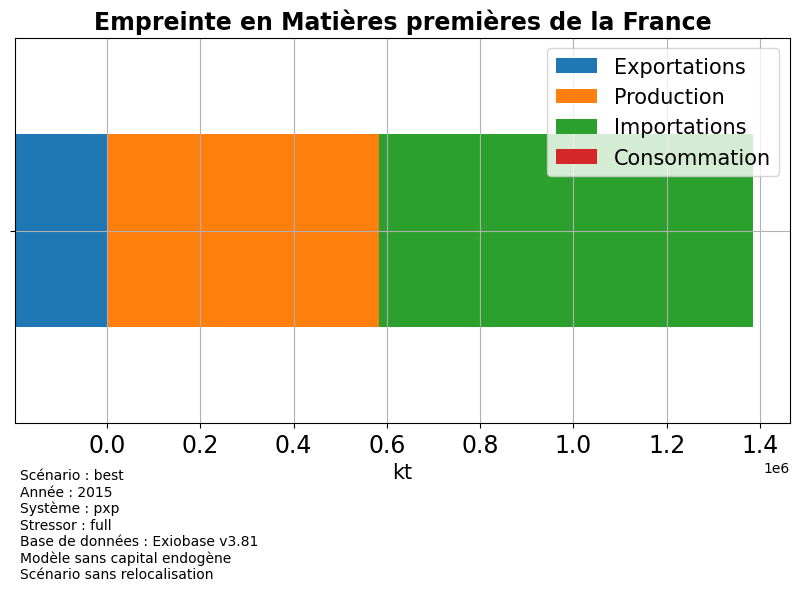

In [23]:
model_no_cap.plot_footprint_FR('best', 'GES')
model_no_cap.plot_footprint_FR('worst', 'GES')

model_no_cap.plot_footprint_FR('best', 'Matières premières')

In [47]:
plot_impacts_by_exporting_country_for_one_product(model_no_cap, sector="Clothing",country_importing="FR", stressors_to_display = 'GES', scope =3)
plot_impacts_location_for_one_product(model_no_cap , 'Clothing',country_importing="FR",stressors_to_display = 'GES')


In [18]:
plot_impacts_by_exporting_country_for_one_product(model_no_cap, sector="Electronics",country_importing="FR", stressors_to_display = 'Matières premières', scope =3)
plot_impacts_location_for_one_product(model_no_cap , 'Electronics',country_importing="FR",stressors_to_display = 'Matières premières')


In [26]:
plot_emission_location_import_distrib_full(model_no_cap ,sectors=['Clothing', 'Electronics'],country_importing="FR",normalized_quantity=True,scenarios=None,stressors_to_display='GES',scope=3)

In [28]:
plot_sector_import_distrib_full(model_no_cap ,sectors=['Clothing', 'Electronics'],country_importing="FR",normalized_quantity=True,scenarios=None,stressors_to_display='Matières premières',scope=3)

In [29]:
plot_sector_import_distrib(iot= model_no_cap.iot,sectors=['Clothing', 'Electronics'],country_importing="FR",normalized_quantity=True)

In [17]:
emission_import_distrib_one_sector(model_no_cap, sector="Electronics",country_importing="FR", stressor_list = ['Metal Ores'], scope =3)


('scope', '=3)')

In [76]:
model_no_cap.iot.stressor_extension.S.loc[['Forestry', 'Primary Crops']]

region                 FR                                   \
sector        Agriculture Crude coal Crude oil Natural gas   
Forestry         0.498152        0.0       0.0         0.0   
Primary Crops    1.584218        0.0       0.0         0.0   

region                                                                      \
sector        Extractive industry Biomass_industry Clothing Heavy_industry   
Forestry                      0.0              0.0      0.0            0.0   
Primary Crops                 0.0              0.0      0.0            0.0   

region                                 ...             EU               \
sector        Construction Automobile  ... Heavy_industry Construction   
Forestry               0.0        0.0  ...            0.0          0.0   
Primary Crops          0.0        0.0  ...            0.0          0.0   

region                                                                  \
sector        Automobile Oth transport equipment Machinery Electronics   
Forestry             0.0                     0.0       0.0         0.0   
Primary Crops        0.0                     0.0       0.0         0.0   

region                                                                        
sector        Fossil fuels Electricity and heat Transport services Composite  
Forestry               0.0                  0.0                0.0       0.0  
Primary Crops          0.0                  0.0                0.0       0.0  

[2 rows x 187 columns]

In [96]:
from src.stressors import GHG_PARAMS,GHG_AND_MATERIALS_PARAM
print(GHG_PARAMS.keys())
print(GHG_AND_MATERIALS_PARAM['unit'])

dict_keys(['name_FR', 'name_EN', 'unit', 'proxy'])
kgCO2eq_or_kt
